# Решающее дерево, Случайный лес, Ансамбль моделей (Bagging, RF)

#### Данный ноутбук представляет собой краткий конспект теории и выполнение практических заданий

Структура:  
1. Решающее дерево для задачи классификации  
        1.1 Классификация на искусственно сгенерированных данных
        1.2 Классификация для определения подлинности банкноты  
2. Решающее дерево для задачи регрессии  
        2.1 Регрессия на искусственно сгенерированных данных  
        2.2 Регрессия для предсказания потребления топлива  
3. Ансамбль моделей
        3.1 Беггинг. Реализация бэггинга для деревьев решений. Метод случайных подпространств (RSS)  
        3.2 Случайный лес (Теория и решение различных задач с применением этого алгоритма)        

In [28]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import (train_test_split, KFold, LeaveOneOut, cross_val_score, cross_validate,
                                     StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (mean_squared_error, log_loss, accuracy_score, balanced_accuracy_score,
                            precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve,
                            average_precision_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.datasets import make_blobs, load_digits

# 1. Решающее дерево для задачи классификации   
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Документация DecisionTreeClassifier Sklearn</a>   
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html">Документация DecisionTreeRegressor Sklearn</a>

**Формально дерево решений — это связный ациклический граф**  
Дерево строится жадно, начиная с одной вершины, разбивает её на две, после чего рекурсивно повторяет процедуру для новых дочерних вершин.

В дереве решений можно выделить **три типа вершин:**  
- Корневая вершина (root node) — откуда объекты из выборки начинают движение по дереву.  
- Внутренние вершины (intermediate nodes) - признак проверяется на некий логический критерий, по результатам которого объект движется глубже по дереву.    
- Листья (leafs) — самые глубокие вершины дерева, в которых содержится «ответ». Для решения задачи классификации возвращается наиболее популярный класс. Для регрессии, если функционал среднеквадратичная ошибка - возвращается усредненное значение. Ошибка оптимизируется при помощи **критериев информативности (Энтропия Шеннона, Джини)**.  

Формула энтропийного критерия информативности:   
(где Pk - вероятность встретить объект k-го класса в подвыборке)    
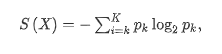

Формула критерия информативности Джини:   
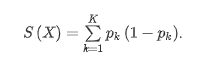

**IG (information Gain - прирост информации)** - изменение критерия информативности до и после разделения. Показывает насколько изменилась информативность при данном разделении.  
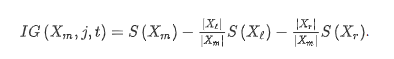


**Борьба с переобучением:**  
- Задать порог по мере неопределённости  
- Задать порог на глубину  
- Задать порог по размеру узла  
- Задать порог на размер потомков

## 1.1 Классификация на искусственно сгенерированных данных

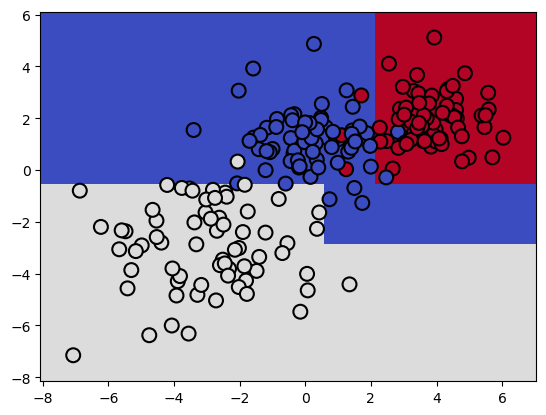

In [ ]:
# Сгенерируем данные, обучим модель и отобразим на графике
RANDOM_SEED = 139

train_data, train_labels = make_blobs(n_samples = 200, centers = [(0, 1), (-3, -3), (4, 2)],
                                      n_features = 2, random_state = RANDOM_SEED,
                                      cluster_std = (1.2, 1.5, 1,))

# Функция для визуализации
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Обучим решающее дерево
clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3,
                                  random_state = RANDOM_SEED)
clf_tree.fit(train_data, train_labels)

# Отрисуем разделяющую поверхность
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(),
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap = 'coolwarm')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100,
            cmap = 'coolwarm', edgecolors = 'black', linewidth = 1.5);

## 1.2 Классификация для определения подлинности банкноты

Определим, является ли банкнота настоящей.  
В задании используется датасет bill_authentication.csv. Целевая переменная - Class.  
- Разделим выборку на обучающую и тестовую (test_size = 0.2, random_state = 17 для разбиения и построения дерева).
- Обучим модель и посчитаем значение F1-scorе (параметры: максимальная глубина дерева = 3, максимальное число признаков, по которым ищется лучшее разбиение в дереве = 2).  

In [ ]:
# Загрузим датасет и посмотрим на данные
bill_authentication = pd.read_csv('bill_authentication.csv')
display(bill_authentication.head(3))
display(bill_authentication.info())

,Variance,Skewness,Curtosis,Entropy,Class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variance  1372 non-null   float64
 1   Skewness  1372 non-null   float64
 2   Curtosis  1372 non-null   float64
 3   Entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


None

In [ ]:
# Разобьем выборку на тренировочную и тестовую, обучим классификатор и посчитаем значение F1-score
X, y = bill_authentication.iloc[:, :-1].values, bill_authentication.iloc[:, -1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 17)

model = DecisionTreeClassifier(max_depth = 3, random_state = 17, max_features = 2).fit(X_train, y_train)
y_pred = model.predict(X_valid)

f1 = f1_score(y_valid, y_pred)
print(f'f1_score = {f1:.03}')

f1_score = 0.866


# 2. Решающее дерево для задачи регрессии

В случае регрессии (прогнозирования непрерывного числового признака) идея построения остается той же, но оптимизируется критерий  информативности, оценивающий разброс вещественных ответов:  
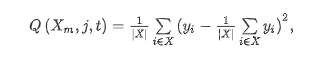

## 2.1 Регрессия на искусственно сгенерированных данных  

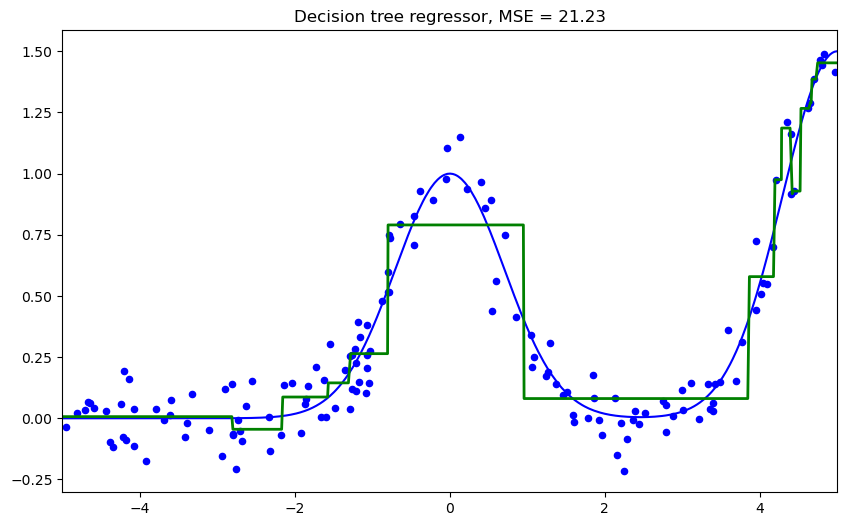

In [ ]:
# Сгенерируем данные, обучим регрессор и отобразим на графике
RANDOM_SEED = 139

n_train = 150
n_test = 1000
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 5) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 5) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples = n_train, noise = noise)
X_test, y_test = generate(n_samples = n_test, noise = noise)

reg_tree = DecisionTreeRegressor(max_depth = 4, random_state = RANDOM_SEED)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize = (10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c = "b", s = 20)
plt.plot(X_test, reg_tree_pred, "g", lw = 2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

## 2.2 Регрессия для предсказания потребления топлива  

В задании используется датасет petrol_consumption.csv.   
- Разобьем выборку на обучающую и тестовую.
- Обучим модель и вычислим RMSE (параметры: test_size = 0.3, random_state = 42 для разбиения и дерева).

In [23]:
# Загрузим датасет и посмотрим на данные
petrol_cons = pd.read_csv('petrol_consumption.csv')
display(petrol_cons.head(3))
display(petrol_cons.info())

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Petrol_tax                    48 non-null     float64
 1   Average_income                48 non-null     int64  
 2   Paved_Highways                48 non-null     int64  
 3   Population_Driver_licence(%)  48 non-null     float64
 4   Petrol_Consumption            48 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


None

In [ ]:
# Разделим выборку, обучим модель и посчитаем значение RMSE
X, y = petrol_cons.iloc[:, :-1].values, petrol_cons.iloc[:, -1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

petrol_model = DecisionTreeRegressor(max_depth = 11, random_state = 42, max_features = 4).fit(X_train, y_train)
y_pred = petrol_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'RMSE: {rmse:.04}')

RMSE: 87.97


# 3. Ансамбль моделей (Bagging)  
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html">Документация BaggingClassifier Sklearn</a>     
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html">Документация BaggingRegressor Sklearn</a>   


**Bagging (Bootstrap Aggregating) — частный случай ансамблирования, параллельный способ построения ансамбля, основанный на статистическом методе bootstrap.**      
Это метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решение посредством голосования среди всех алгоритмов (простым или взвешенным голосованием). В группе модели снижают сдвиг и разброс ответов (bias and variance).   
В основе бэггинга лежит статистический метод **бутстрэп** (bootstrap - генерация выборок из исходного датасета путем случайного выбора элементов с повторениями.). Бутстрэп-выборки также часто используются для оценки различных статистических показателей (например, разброса или доверительного интервала). При бэггинге размер каждой бутстрэп-выборки должен совпадать с размером исходной выборки.

Коротко о способе построения ансамбля моделей Bagging:  
- Обучающая выборка сэмплируется k раз с помощью **bootstrap (выбор с возвращением)**.  
- На каждом сэмпле обучается **отдельная базовая модель**.
- Ответы моделей **усредняются (возможно, с весами - "ансамбль с голосованием")**.

## 3.1 Реализация бэггинга для деревьев решений
В задании используется датасет с информацией о качестве вина.    
- **Обучим логистическую регрессию, решающее дерево и бэггинг. Сравним результаты построенных моделей.**    
- Подготовим данные, обучим два классификатора (лог. регрессию и решающее дерево), посчитаем значение F1_score.  
- Затем обучим модель с использованием бэггинга (BaggingClassifier) для алгоритма, показавшего лучшее качество.  


In [ ]:
# Загрузим датасет и посмотрим на данные
wine_qual = pd.read_csv('winequality-red.csv', sep = ';')
display(wine_qual.head(3))
display(wine_qual.info())
print(f'\nЗначения целевой переменной в исходном датасете: \n{wine_qual.quality.value_counts()}')

# Сконвертируем целевой стобец в бинарные значения
wine_qual.quality = wine_qual.quality.isin([6, 7, 8]).astype('int32')
print(f'\nЗначения целевой переменной после трансформации: \n{wine_qual.quality.value_counts()}')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None


Значения целевой переменной в исходном датасете: 
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Значения целевой переменной после трансформации: 
1    855
0    744
Name: quality, dtype: int64


In [ ]:
# Разделим выборку на test и valid
X, y = wine_qual[list(set(wine_qual.columns) - set(['quality']))].values, wine_qual.quality.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Обучим модель Логистической регрессии с параметрами по умолчанию и посчитаем f1_score
model_LR = LogisticRegression().fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_valid)
f1_LR = f1_score(y_valid, y_pred_LR)
print(f'Логистическая регрессия. F1_score = {f1_LR:.05}')

# Обучим модель решающего дерева (С параметрами из условия задачи)
model_tree = DecisionTreeClassifier(random_state = 42, max_depth = 10).fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_valid)
f1_tree = f1_score(y_valid, y_pred_tree)
print(f'Дерево решений. F1_score = {f1_tree:.05}')

# Обучим бэггинг над решающими деревьями (С параметрами из условий задачи)
model_bg = BaggingClassifier(base_estimator = model_tree, random_state = 42, n_estimators = 1500).fit(X_train, y_train)
y_pred_bg = model_bg.predict(X_valid)
f1_bg = f1_score(y_valid, y_pred_bg)
print(f'Беггинг над деревьями решений. F1_score = {f1_bg:.05}')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Логистическая регрессия. F1_score = 0.74621
Дерево решений. F1_score = 0.77117
Беггинг над деревьями решений. F1_score = 0.81664


Беггинг над решающими деревьями показал более высокое качество по сравнению с отдельными моделями.

### Метод случайных подпространств (RSS - Random Subspaces)  
Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.  
RSS позволяет снизить скоррелированность между деревьями и избежать переобучения. Метод обеспечивает устойчивость алгоритма к набору доступных признаков.

## 3.2 Случайный лес  
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Документация RandomForestClassifier Sklearn</a>  
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">Документация RandomForestRegressor Sklearn</a>

**Случайный лес** — это ансамблевый алгоритм, это композиция глубоких деревьев, которые строятся независимо друг от друга, это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.  

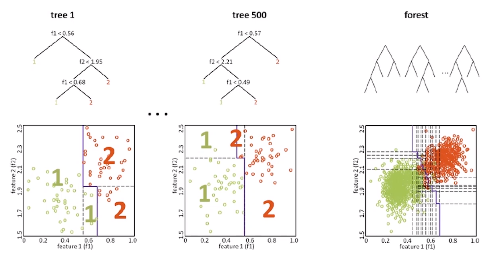

**Алгоритм построения Случайного леса**  

Для каждого дерева:  
- сгенерировать выборку при помощи статистического метода бутстрэп (сэмплирование с повоторениями);
- построить решающее дерево по выборке: по заданному критерию выбирается лучший признак, по которому происходит разбиение в дереве и так до исчерпания выборки → дерево строится, пока не сработает критерий остановки (порог на глубину, порог на размер потомков, порог на размер узла) → при каждом разбиении сначала выбирается несколько случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них.  

Случайный лес обучает набор деревьев (параметр n_esimators), каждое из которых учится на подмножестве признаков (RSS - Random Subspaces) и на подмножестве объектов (Bootstrap). Ответы агрегируются при помощи голосования. Как правило, в задачах классификации берут квадратный корень из числа признаков, а в задачах регрессии — треть числа признаков или log.

### УПРАЖНЕНИЕ   
###  Реализация Случайного леса для предсказания погоды
- В задании используется датасет c данными о погоде temps_extended.csv.  
- Проведем небольшую предобработку: удалим признаки, не относящиеся к предсказанию.  
- Разделим выборки, обучим модель и посчитаем значение метрик качества.  
- Подберем параметры при помощи класса **RandomizedSearchCV**. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">Документация Sklearn</a>  

In [ ]:
# Загрузим датасет и посмотрим на данные
weather = pd.read_csv('temps_extended.csv')
display(weather.head(3))
display(weather.info())

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.0,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.0,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.0,0,40,39,45.8,42,42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     2191 non-null   int64  
 1   month    2191 non-null   int64  
 2   day      2191 non-null   int64  
 3   weekday  2191 non-null   object 
 4   ws_1     2191 non-null   float64
 5   prcp_1   2191 non-null   float64
 6   snwd_1   2191 non-null   int64  
 7   temp_2   2191 non-null   int64  
 8   temp_1   2191 non-null   int64  
 9   average  2191 non-null   float64
 10  actual   2191 non-null   int64  
 11  friend   2191 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 205.5+ KB


None

In [ ]:
# Удалим некоторые признаки и разделим выборку на обучающую и тестовую
y = weather['actual']
X = weather.drop(['actual','weekday','month','day','year'], axis = 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Посмотрим параметры модели по умолчанию
rf = RandomForestRegressor(random_state = 42)
print('Параметры по умолчанию:\n')
pprint(rf.get_params())

Параметры по умолчанию:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Подберем значения для следующих параметров: n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf и bootstrap

In [ ]:
# Подберем значения для параметров
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Обучим модель с параметрами, предложенными RandomizedSearchCV
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3,
            verbose = 3, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [ ]:
# Посмотрим, какие гиперпараметры предлагаются как оптимальные
print('Подобранные гиперпараметры:')
display(rf_random.best_params_)

# Посмотрим на значение MSE с дефолтными и подобранными параметрами
rf = RandomForestRegressor(random_state = 42).fit(X_train, Y_train)
Y_pred_default = rf.predict(X_val)
mse1 = mean_squared_error(Y_val, Y_pred_default)
print(f'Значение MSE при использовании параметров RandomForest по умолчанию: {mse1:.05}')

Y_pred_random = rf_random.predict(X_val)
mse2 = mean_squared_error(Y_val, Y_pred_random)
dif_mse = mse1 - mse2
print(f'Значение MSE с параметрами, подобранными с помощью RandomizedSearchCV: {mse2:.05}')
print(f'Улучшение значения MSE при использовании подобранных параметров: {dif_mse:.05}')

Подобранные гиперпараметры:


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

Значение MSE при использовании параметров RandomForest по умолчанию: 24.571
Значение MSE с параметрами, подобранными с помощью RandomizedSearchCV: 23.101
Улучшение значения MSE при использовании подобранных параметров: 1.4701


### УПРАЖНЕНИЕ  
### Реализация Случайного леса на примере датасета с информацией о сотрудниках компании  
В задании используется датасет HR-dataset.csv. Целевая переменная 'left'- обозначает, уволился ли сотрудник из компании.   
- Проведем небольшую предобработку.  
- Обучим несколько алгоритмов и оценим их качество на кросс-валидации на пяти фолдах при помощи Accuracy.

In [29]:
# Загрузим датасет и проведем базовую предобработку данных
hr_data = pd.read_csv('HR-dataset.csv')
display(hr_data.head(3))
display(hr_data.info())

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
0,1001,0.38,0.53,2,157,3,0,1,0,sales,low
1,1002,0.80,0.86,5,262,6,0,1,0,sales,medium
2,1003,0.11,0.88,7,272,4,0,1,0,sales,medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   dept                   14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


None

In [ ]:
# Удалим признак, который отвечает за идентификатор пользователя, как нерепрезентативный
# Разделим выборку на Х и y
target = 'left'
features = hr_data.columns.drop(target)
features = features.drop('empid')
X, y = hr_data[features].copy(), hr_data[target]

# Заменим идентификатор отдела, к которому относился сотрудник, на количество людей в отделе
X['dept'] = X['dept'].apply(X['dept'].value_counts().get)

# Заменим признак salary на ординальную категорию
salary_ord = {'low': 1, 'medium': 2, 'high': 3}
X['salary'] = X['salary'].apply(salary_ord.get)

# Масштабируем признаки
scaler = StandardScaler()
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)

# Будем оценивать качество модели на кросс-валидации на пяти фолдах при помощи Accuracy
def estimate_accuracy(clf, X, y, cv = 5):
    return cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy').mean()

# Сравним точность одного дерева и композиции древьев
tree = DecisionTreeClassifier(max_depth = 30)
print('Decision tree: {:.06}'.format(estimate_accuracy(tree, X, y)))

bagging_trees = BaggingClassifier(tree)
print('Decision tree bagging: {:.06}'.format(estimate_accuracy(bagging_trees, X, y)))

Decision tree: 0.974665
Decision tree bagging: 0.988266


Ансамбль деревьев показал более высокий результат по сравнению с одним решающим деревом. Структура дерева сильно зависит от обучающей выборки. Если немного изменить обучающую выборку, то дерево значительно изменится. Ансамбль алгоритмов позволяет нивелировать вклад ошибок отдельных классификаторов. В группе алгоритмы дают более низкое смещение и разброс ответов (bias and variance).

In [ ]:
# Увеличим различность построенных деревьев
random_tree = DecisionTreeClassifier(max_features = int(np.sqrt(len(features))), max_depth = 30)
print("Random tree: {:.06}".format(estimate_accuracy(random_tree, X, y)))

bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging: {:.06}".format(estimate_accuracy(bagging_random_trees, X, y)))

Random tree: 0.978599
Random tree bagging: 0.9906


**Именно так и работает случайный лес (Random Forest): он обучает набор деревьев (параметр n_esimators), каждое из которых обучается на подмножестве признаков (RSS - Random Subspaces) и подмножестве объектов (Bootstrap)**. Ответы агрегируются при помощи голосования.  

Как правило, в задачах классификации берут квадратный корень из числа признаков, а в задачах регрессии — треть числа признаков или log.

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100,
                                       n_jobs = -1,
                                       max_features = int(np.sqrt(len(features))),
                                       max_depth = 30)
print(f'Random Forest: {estimate_accuracy(random_forest, X, y):.04}')

Random Forest: 0.992


Ещё одним преимуществом Bagging является получение оценки работы классификатора при помощи **out-of-bag score (oobs)** без дополнительной кросс-валидации. **Параметр oob_score = True** (имеет смысл при достаточном количестве деревьев).

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100,
                                       max_features = int(np.sqrt(len(features))),
                                       max_depth = 30,
                                       oob_score  =True,
                                       n_jobs = -1)
random_forest.fit(X, y)
print(f'Out-of-bag score: {random_forest.oob_score_.mean():.04}')

Out-of-bag score: 0.9932


#### Метод бэггинга можно применять к произвольным алгоритмам, например, к логистической регрессии.  
В её случае он не так хорошо повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки.  
Беггинг хорошо подходит для агрегации именно решающих деревьев, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различаются.

In [ ]:
# Обучим логистическую регрессию и беггинг
lr = LogisticRegression(solver = 'saga', max_iter = 200).fit(X, y)
print("LR: {:.04}".format(estimate_accuracy(lr, X, y)))

random_logreg = BaggingClassifier(lr, n_estimators = 10, n_jobs = -1, random_state = 42)
print("Bagging for LR: {:.04}".format(estimate_accuracy(random_logreg, X, y)))

# Уберем часть признаков
random_logreg = BaggingClassifier(lr, n_estimators = 10, n_jobs = -1, max_features = 0.5, random_state = 42)
print(f"\nСокращенное число признаков. Bagging for LR: {estimate_accuracy(random_logreg, X, y):.04}")

LR: 0.771
Bagging for LR: 0.7701

Сокращенное число признаков. Bagging for LR: 0.757


В случае логистической регрессии повышение разнообразности моделей не даёт такого прироста, как с деревьями, поскольку модели сильно теряют в качестве. Случайный лес на примере этой задачи работает лучше.

### УПРАЖНЕНИЕ   
### Классификация изображений с цифрами по численным признакам  
В задании используется датасет digits из sklearn.datasets.   

In [2]:
# Загрузим данные
data = load_digits()
digits = pd.DataFrame(data['data'], columns = data['feature_names'])
digits['answer'] = data['target']
display(digits.head(3))

# Посмотрим на уникальные значения целевой переменной
print(f'\nУникальные значения целевой переменной: {digits.answer.unique()}')
digits.answer.value_counts()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,answer
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2



Уникальные значения целевой переменной: [0 1 2 3 4 5 6 7 8 9]


3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: answer, dtype: int64

In [3]:
# Разделим данные на X и y
# X, y = digits.iloc[:, :-1], digits.iloc[:, -1]
# X, y = digits.drop('answer', axis = 1), digits.answer
X, y = digits[list(set(digits.columns) - set(['answer']))].values, digits.answer.values

# Обучим DecisionTreeClassifier с настройками по умолчанию и измерим качество при помощи cross_val_score
tr = DecisionTreeClassifier()
cross_v_score1 = cross_val_score(tr, X, y, cv = 10, n_jobs = -1).mean()
print(f'DecisionTreeClassifier с настройками по умолчанию, cross_val_score: {cross_v_score1:.04}')

# Обучим BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию и измерим качество
bg = BaggingClassifier(tr, n_estimators = 100)
cross_v_score2 = cross_val_score(bg, X, y, cv = 10, n_jobs = -1).mean()
print(f'BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию, cross_val_score: {cross_v_score2:.04}')

DecisionTreeClassifier с настройками по умолчанию, cross_val_score: 0.8336
BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию, cross_val_score: 0.926


Результаты показывают, что ансамбль моделей работает лучше, чем одиночное дерево.

- Изменим параметр max_features, отвечающий за кол-во признаков для обучения. В задачах классификации часто используется корень из числа признаков. В задачах регрессии часто берут число признаков, деленное на три или log.

In [ ]:
bg_sqrt = BaggingClassifier(tr, n_estimators = 100, max_features = int(np.sqrt(len(digits.drop('answer', axis = 1).columns))))
cross_v_score3 = cross_val_score(bg_sqrt, X, y, cv = 10, n_jobs = -1).mean()
print('BaggingClassifier на основе DecisionTreeClassifier с измененными настройками max_features(sqrt). \nЗначение cross_val_score: {:.04}'.format(cross_v_score3))

BaggingClassifier на основе DecisionTreeClassifier с измененными настройками max_features(sqrt). 
Значение cross_val_score: 0.9321


На предыдущем примере мы выбирали подмножество один раз для каждого очередного дерева. Следующим шагом будет построение бэггинга на основе деревьев, которые выбирают случайное подмножество признаков для каждой вершины дерева.

In [ ]:
# Построим бэггинг на рандомизированных деревьях
tr_random = DecisionTreeClassifier(max_features = 'sqrt')
bg_random = BaggingClassifier(tr_random, n_estimators = 100)
cross_v_score4 = cross_val_score(bg_random, X, y, cv = 10, n_jobs = -1).mean()
print(f'Бэггинг на рандомизированных деревьях. Значение cross_val_score: {cross_v_score4:.04}')

Бэггинг на рандомизированных деревьях. Значение cross_val_score: 0.9549


Мы проиллюстрировали пример бэггинга на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest.  

#### Сравним качество работы предыдущего классификатора с RandomForestClassifier.

In [6]:
rf = RandomForestClassifier()
cross_v_score5 = cross_val_score(rf, X, y, cv = 10, n_jobs = -1).mean()
('Модель RandomForestClassifier. Значение cross_val_score: {:.04}'.format(cross_v_score5))

'Модель RandomForestClassifier. Значение cross_val_score: 0.9532'

### УПРАЖНЕНИЕ   
### Классификатор, который предсказывает выжил ли пассажир Титаника
**Посмотрим, как качество алгоритма DecisionTreeClassifier от глубины дерева. Для наглядности построим график.**  
- Проведем базовую предобработку,  
- Обучим 100 деревьев с глубиной от 1 до 100,  
- Предскажем значения на тренировочной и тестовой выборках,  
- Построим график зависимости качества классификации от глубины дерева,  
- Используем GridSearchCV для подбора параметров. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">Документация Sklearn</a>

In [32]:
# Загрузим датасет и посмотрим на данные
titanic = pd.read_csv('titanic.csv')
display(titanic.head(3))
display(titanic.info())
display(titanic.isnull().sum())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Исключим из датасета некоторые признаки:**  
- PassengerId (неинформативный),
- Name (уникальная особенность конкретно взятого пассажира),  
- Ticket (строковый идентификатор, который показывает, какой билет приобрел пассажир),  
- Cabin (большая часть данных пропущена),  

In [33]:
# Разделим выборку на X и Y
X, y = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis = 1),  titanic.Survived
display(X.head(3))
display(y.head(3))

# Заполним пропуски в колонке Age медианным значением
# X = X.fillna({'Age' : X.Age.median()})
X.Age = X.Age.fillna(X.Age.median())

# Преобразуем номинативные переменные
X = pd.get_dummies(X)
display(X.head(3))

# Разделим выборку на обучающую и тестовую
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S


0    0
1    1
2    1
Name: Survived, dtype: int64

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1


0.8266
0.7799


[Text(0.44, 0.9, 'Fare <= 10.481\nentropy = 0.951\nsamples = 623\nvalue = [392, 231]\nclass = Died'),
 Text(0.2, 0.7, 'Sex_female <= 0.5\nentropy = 0.712\nsamples = 236\nvalue = [190, 46]\nclass = Died'),
 Text(0.08, 0.5, 'Age <= 7.71\nentropy = 0.519\nsamples = 189\nvalue = [167, 22]\nclass = Died'),
 Text(0.04, 0.3, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Survived'),
 Text(0.12, 0.3, 'Fare <= 8.206\nentropy = 0.505\nsamples = 188\nvalue = [167, 21]\nclass = Died'),
 Text(0.08, 0.1, 'entropy = 0.55\nsamples = 165\nvalue = [144, 21]\nclass = Died'),
 Text(0.16, 0.1, 'entropy = 0.0\nsamples = 23\nvalue = [23, 0]\nclass = Died'),
 Text(0.32, 0.5, 'Fare <= 9.413\nentropy = 1.0\nsamples = 47\nvalue = [23, 24]\nclass = Survived'),
 Text(0.28, 0.3, 'Fare <= 7.744\nentropy = 0.971\nsamples = 40\nvalue = [16, 24]\nclass = Survived'),
 Text(0.24, 0.1, 'entropy = 0.65\nsamples = 12\nvalue = [2, 10]\nclass = Survived'),
 Text(0.32, 0.1, 'entropy = 1.0\nsamples = 28\nvalue = [14, 14]\

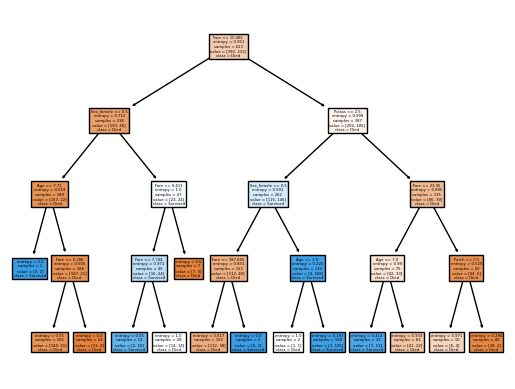

In [ ]:
# Обучим простую модель и посмотрим ее качество
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 42,
                             max_features = int(np.sqrt(len(X.columns))))
clf.fit(X_train, y_train)
print(round(clf.score(X_train, y_train), 4))
print(round(clf.score(X_valid, y_valid), 4))

tree.plot_tree(clf, feature_names = list(X), class_names = ['Died', 'Survived'], filled = True)

На тренировочной выборке качество классификатора довольно высокое, на валидационной гораздо ниже.


**Обучим 100 деревьев с глубиной от 1 до 100, предскажем значения на тренировочной и тестовой выборках, сохраним точность получившейся классификации в датафрейме и построим график зависимости качества классификации от глубины дерева.**

In [35]:
# Установим значения глубины деревьев, которые мы будем перебирать и количество признаков для каждого разбиения
max_depth_values = range(1, 101)
max_features = int(np.sqrt(len(X.columns)))

# Создадим датафрейм
scores_data = pd.DataFrame()

# Создадим цикл для перебора параметров глубины дерева
for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_features = max_features, max_depth = max_depth, random_state = 42)
    clf.fit(X_train, y_train)
    train_score = round(clf.score(X_train, y_train), 4)
    test_score = round(clf.score(X_valid, y_valid), 4)
    temp_score_data = pd.DataFrame({'max_depth' : [max_depth], 'train_score' : [train_score], 'test_score' : [test_score]})

    # scores_data.append(temp_score_data)
    scores_data = pd.concat([scores_data, temp_score_data])

display(scores_data)

,max_depth,train_score,test_score
0,1,0.6292,0.5858
0,2,0.7849,0.7910
0,3,0.7897,0.7761
0,4,0.8266,0.7799
0,5,0.8427,0.7873
...,...,...,...
0,96,0.9807,0.7463
0,97,0.9807,0.7463
0,98,0.9807,0.7463
0,99,0.9807,0.7463


In [36]:
# Развернем датасет, чтобы для каждой глубины дерева было два значения score для тренировочной и тестовой выборки
score_data_long = pd.melt(scores_data, id_vars = 'max_depth', value_vars = ['train_score', 'test_score'],
                                        var_name = 'set_type', value_name = 'score')
display(score_data_long)

,max_depth,set_type,score
0,1,train_score,0.6292
1,2,train_score,0.7849
2,3,train_score,0.7897
3,4,train_score,0.8266
4,5,train_score,0.8427
...,...,...,...
195,96,test_score,0.7463
196,97,test_score,0.7463
197,98,test_score,0.7463
198,99,test_score,0.7463


<AxesSubplot:xlabel='max_depth', ylabel='score'>

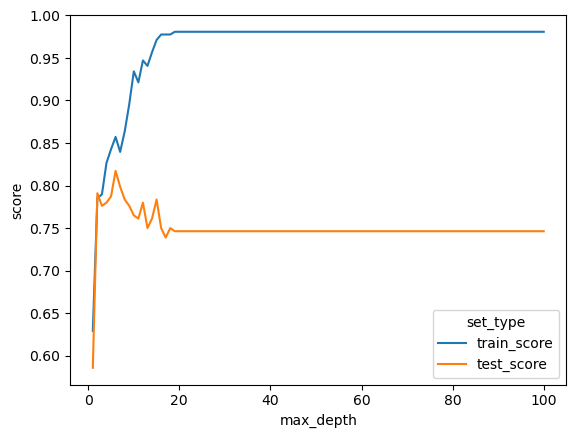

In [37]:
# Посмотрим на значения score на тренировочной и тестовой выборке в зависимости от глубины дерева
sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = score_data_long)

- По графику видно, что на тренировочном наборе данных с увеличением глубины дерева качество (score) увеличивается, модель все более безошибочно классифицирует набор данных, на котором она обучалась.    
- На тестовом наборе данных изначально при невысокой глубне показатель score довольно низкий, это означает, что модель еще не обучилась. Далее на промежутке, где глубина дерева приблизительно равна 10 качество модели достигает максимальный показатль. Можно предположить, что это тот самый промежуток, когда модель наилучшим образом улавливает некоторую закономерность в данных. Далее вместе с увеличением показателя train_score показатель test_score начинает постепенно снижаться.    
- Это означает, что при очень низких показателях грубины дерева модель была недообучена, затем она достигла оптимального показателя, а дальшейшее углубление дерева привело к его переобучению.

#### Обучим модель и применим кросс-валидацию

In [38]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, max_features = max_features, random_state = 42)

# Протестируем классификатор с помощью кросс-валидации и посмотрим на точность модели
CV_score = cross_val_score(clf, X_train, y_train, cv = 5)

# Получим среднюю точность на кросс-валидации
CV_score_mean = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 3)
print(f'Набор показателей точности (cross_val_score, cv = 5): {CV_score}.\nУсредненный показатель точности: {CV_score_mean}')

Набор показателей точности (cross_val_score, cv = 5): [0.784      0.872      0.704      0.75806452 0.82258065].
Усредненный показатель точности: 0.788


Подкорректируем функцию для подбора параметра глубины дерева.  
На каждой итерации будем рассчитывать среднюю точность на кросс-валидации и сохранять этот показатель в датасет.

In [39]:
max_depth_values = range(1, 100)   # Значения глубины деревьев, которые мы будем перебирать

scores_data = pd.DataFrame()       # Датафрейм, в который поместим итоговые данные

# Цикл для подбора параметров глубины дерева
for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth, random_state = 42,
                                 max_features = max_features).fit(X_train, y_train)

    train_score = round(clf.score(X_train, y_train), 4)   # Показатели точности на тренировочной и тестовой выборках
    test_score = round(clf.score(X_valid, y_valid), 4)

    mean_cross_val_score = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)

    temp_score_data = pd.DataFrame({'max_depth' : [max_depth],
                                    'train_score' : [train_score],
                                    'test_score' : [test_score],
                                    'cross_val_score' : [mean_cross_val_score]
                                    })

    # scores_data.append(temp_score_data)
    scores_data = pd.concat([scores_data, temp_score_data])

display(scores_data)

,max_depth,train_score,test_score,cross_val_score
0,1,0.6292,0.5858,0.6228
0,2,0.7849,0.7910,0.7785
0,3,0.7897,0.7761,0.7705
0,4,0.8266,0.7799,0.7881
0,5,0.8427,0.7873,0.7978
...,...,...,...,...
0,95,0.9807,0.7463,0.7673
0,96,0.9807,0.7463,0.7673
0,97,0.9807,0.7463,0.7673
0,98,0.9807,0.7463,0.7673


In [40]:
# Развернем получившийся датасет, чтобы для каждой глубины дерева было два значения score для тренировочной и тестовой выборки
scores_data_long_cv = pd.melt(scores_data, id_vars = 'max_depth',
                              value_vars = ['train_score', 'test_score', 'cross_val_score'],
                              var_name = 'set_type', value_name = 'score')
display(scores_data_long_cv)

,max_depth,set_type,score
0,1,train_score,0.6292
1,2,train_score,0.7849
2,3,train_score,0.7897
3,4,train_score,0.8266
4,5,train_score,0.8427
...,...,...,...
292,95,cross_val_score,0.7673
293,96,cross_val_score,0.7673
294,97,cross_val_score,0.7673
295,98,cross_val_score,0.7673


<AxesSubplot:xlabel='max_depth', ylabel='score'>

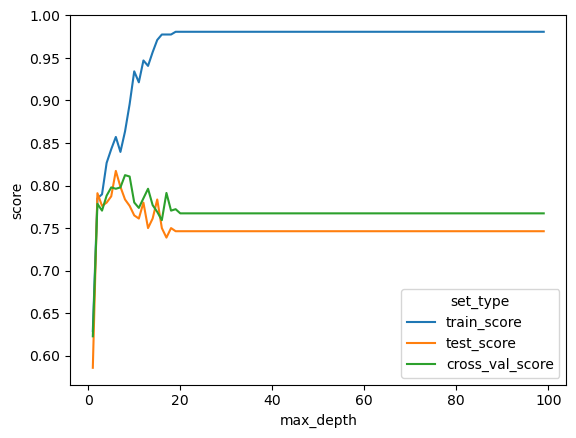

In [41]:
# Построим график
sns.lineplot(data = scores_data_long_cv, x = 'max_depth', y = 'score', hue = 'set_type')

На графике отображается еще одна кривая линия - cross_val_score. Можно заметить, что максимальная средняя точность на кросс-валидации достигается при более высокой глубине дерева. Этот показатель max_depth будет более оптимальным т.к. при нем достигается максимальная точность на кросс-валидации. Посмотрим, при какой именно глубине дерево показывает максимальное значение на косс-валидации.

In [42]:
scores_data_long_cv.query('set_type == "cross_val_score"').sort_values('score', ascending = False)[:10]

,max_depth,set_type,score
205,8,cross_val_score,0.8122
206,9,cross_val_score,0.8106
202,5,cross_val_score,0.7978
204,7,cross_val_score,0.7978
203,6,cross_val_score,0.7962
210,13,cross_val_score,0.7962
214,17,cross_val_score,0.7913
201,4,cross_val_score,0.7881
209,12,cross_val_score,0.7850
207,10,cross_val_score,0.7801


Максимальное значение качества достигается при глубине дерева равным 8 (score = 0.8122)

In [43]:
scores_data_long_cv.query('max_depth == 8')

,max_depth,set_type,score
7,8,train_score,0.8636
106,8,test_score,0.7836
205,8,cross_val_score,0.8122


In [44]:
# Создадим классификатор с глубиной дерева = 8
best_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state = 42, max_features = max_features)

# Проверим модель на тестовых данных
best_clf.fit(X_train, y_train)
print(round(best_clf.score(X_valid, y_valid), 4))

0.7836


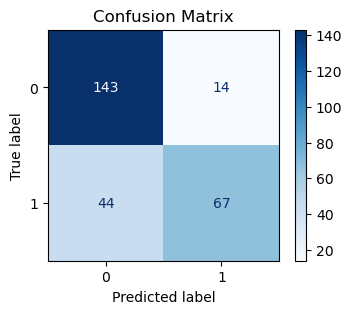

In [73]:
# Изобразим матрицу ошибок
# plot_confusion_matrix(best_clf, X_test, y_test, cmap = plt.cm.Blues, values_format = '.2g')

fig, ax = plt.subplots(figsize = (4, 3), dpi = 100)
ax.set(title = 'Confusion Matrix')
cm = confusion_matrix(y_valid, best_clf.predict(X_valid))
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues, ax = ax)
plt.show()

In [81]:
def ROC_curve_plot(y_valid, y_pred_prob, model):
    # Подсчет и отображение значения ROC кривой и значения площади под кривой AUC
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)

    plt.figure(figsize = (4, 4))
    plt.plot([0, 1], label = 'Baseline', linestyle = '--')
    plt.plot(fpr, tpr, label = 'Model')
    plt.title(f'{model}  ROC AUC = {roc_auc:.03}', fontsize = 10.5)
    plt.ylabel('True Positive Rate (TPR)', fontsize = 10)
    plt.xlabel('False Positive Rate (FPR)', fontsize = 10)
    plt.legend(loc = 'lower right')
    plt.show()

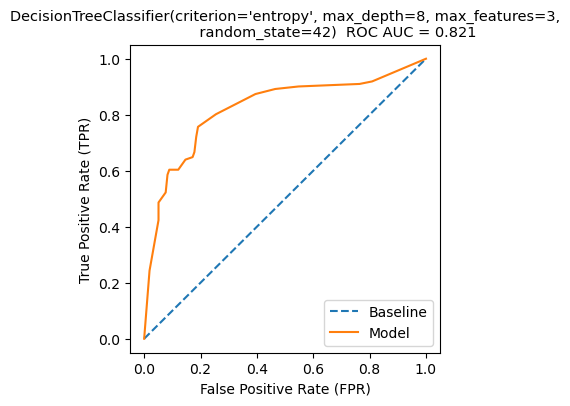

In [82]:
# Отрисуем ROC-кривую
y_pred_prob = best_clf.predict_proba(X_valid)[:, 1]
ROC_curve_plot(y_valid, y_pred_prob, best_clf)

#### Подберем параметры при помощи GridSearchCV

Именно балансировка между такими параметрами как: глубина дерева (max_depth), минимальное число наблюдений в узле, чтобы по нему можно было сделать еще один сплит (min_samples_split), допустимый размер выборки, который мы можем отнести в отдельный исход после сплита (min_samples_leaf), минимальный прирост информации и др. позволяет выбрать оптимальную конфигурацию дерева и достичь наиболее хорошего качества алгоритма.  

In [ ]:
# Создадим классификатор
clf = DecisionTreeClassifier()

# Передадим словарь с параметрами, комбинации которых мы будем проверять на кросс-валидации
parameters = {'criterion' : ['gini', 'entropy'],
              'max_depth' : range(1, 50, 5),
              'max_features' :['auto', 'sqrt', 'log2', None],
              'min_samples_split' : range(5, 50, 5),
              'min_samples_leaf' : range(2, 50, 5)}
grid_search_cv_clf = GridSearchCV(clf, param_grid = parameters, cv = 10, n_jobs = -1).fit(X_train, y_train)

best_params = grid_search_cv_clf.best_params_   # Параметры, которые предлагает GridSearchCV как наиболее оптимальные
best_clf = grid_search_cv_clf.best_estimator_

In [ ]:
# Посчитаем значения метрик качества классификации
precision = precision_score(y_valid, best_clf.predict(X_valid))
recall = recall_score(y_valid, best_clf.predict(X_valid))
f1 = f1_score(y_valid, best_clf.predict(X_valid))

print(f'Best parameters: {best_params},\nPrecision: {round(precision, 3)},\nRecall: {round(recall, 3)},\nF1: {round(f1, 3)}')

# Выведем набор признаков, по которым производились разбиения
feature_importances = [round(x, 4) for x in best_clf.feature_importances_]
feature_importances_df = pd.DataFrame({'features' : list(X_train), 'feature_importances' : feature_importances})
display(feature_importances_df.sort_values('feature_importances', ascending = False))

Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 5},
Precision: 0.83,
Recall: 0.748,
F1: 0.787


,features,feature_importances
5,Sex_female,0.3667
4,Fare,0.2535
0,Pclass,0.1521
1,Age,0.1228
2,SibSp,0.0626
7,Embarked_C,0.0248
9,Embarked_S,0.0106
3,Parch,0.0070
6,Sex_male,0.0000
8,Embarked_Q,0.0000


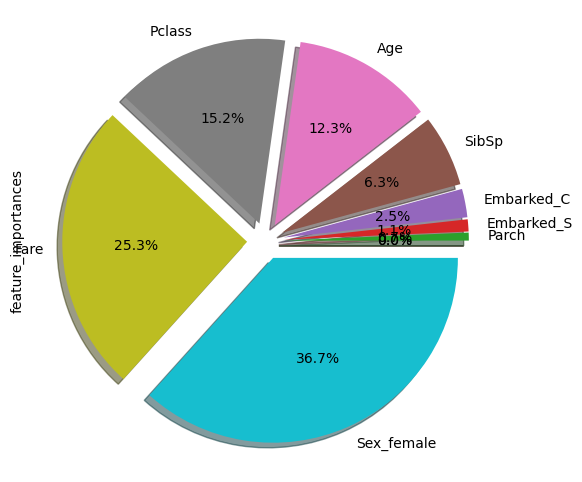

In [ ]:
feature_importances_df = pd.DataFrame({'features' : list(X_train.columns),
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by = 'feature_importances')

feature_importances_df.plot.pie(
                        explode = [0.1] * len(X_train.columns),
                        labels = feature_importances_df.features,
                        y = 'feature_importances',
                        autopct = '%1.1f%%',
                        shadow = True,
                        legend = False,
                        figsize = (6, 6));

<AxesSubplot:>

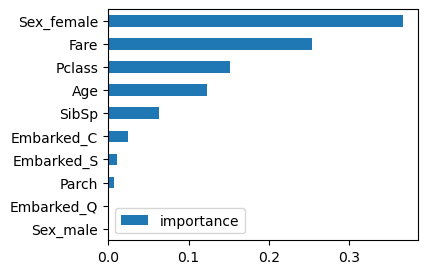

In [ ]:
feature_importances = [round(x, 3) for x in best_clf.feature_importances_]
feature_importances_df_2 = pd.DataFrame(feature_importances, index = X_train.columns, columns = ['importance'])
feature_importances_df_2.sort_values('importance').plot(kind = 'barh', figsize = (4, 3))

#### Обучим Random Forest на том же датасете    
- с дефолтными параметрами,  
- с параметрами, подобранными при помощи RandomizedSearchCV,  
- с параметрами, подобранными при помощи GridSearchCv.

In [ ]:
clf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)
y_pred = clf.predict(X_valid)
y_pred_proba = clf.predict_proba(X_valid)[:, 1]
print(f'Precision: {round(precision_score(y_valid, y_pred), 4)},\nRecall: {round(recall_score(y_valid, y_pred), 4)},\nF1: {round(f1_score(y_valid, y_pred), 4)},\nROC_AUC_score: {round(roc_auc_score(y_valid, y_pred), 4)}')

Precision: 0.7429,
Recall: 0.7027,
F1: 0.7222,
ROC_AUC_score: 0.7654


#### RandomizedSearchCV

In [ ]:
# Параметры, подобранные при помощи RandomizedSearchCV
clf = RandomForestClassifier()
parameters = {'criterion' : ['gini', 'entropy'],
              'max_depth' : range(1, 100, 2),
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'min_samples_split' : range(2, 72, 2),
              'min_samples_leaf' : range(2, 72, 2)
                }

rf_random = RandomizedSearchCV(clf, param_distributions = parameters, cv = 10, n_iter = 100,
                               n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [ ]:
print(rf_random.best_score_)
print(rf_random.best_params_)
rf_random_best = rf_random.best_estimator_

y_pred_rand = rf_random_best.predict(X_valid)
y_pred_proba_rand = rf_random_best.predict_proba(X_valid)[:, 1]
print(f'Precision: {round(precision_score(y_valid, y_pred_rand), 4)},\nRecall: {round(recall_score(y_valid, y_pred_rand), 4)},\nF1: {round(f1_score(y_valid, y_pred_rand), 4)},\nROC_AUC_score: {round(roc_auc_score(y_valid, y_pred_proba_rand), 4)}')

0.8331029185867894
{'min_samples_split': 38, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 45, 'criterion': 'gini'}
Precision: 0.8571,
Recall: 0.6486,
F1: 0.7385,
ROC_AUC_score: 0.8734


#### GridSearchCV

In [ ]:
clf = RandomForestClassifier()
parameters = {'n_estimators' : range(50, 200, 50),
              'max_depth' : range(1, 52, 2),
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'min_samples_split' : range(1, 56, 5),
              'min_samples_leaf' : range(1, 56, 5)
                }

rf_gr = GridSearchCV(clf, param_grid = parameters, cv = 3, n_jobs = -1, verbose = 1).fit(X_train, y_train)

In [8]:
print(rf_gr.best_score_)
print(rf_gr.best_params_)
rf_gr_best = rf_gr.best_estimator_

y_pred_gr = rf_gr_best.predict(X_valid)
y_pred_proba_gr = rf_gr_best.predict_proba(X_valid)[:, 1]

print(f'Precision: {round(precision_score(y_valid, y_pred_gr), 4)},\nRecall: {round(recall_score(y_valid, y_pred_gr), 4)},\nF1: {round(f1_score(y_valid, y_pred_gr), 4)},\nROC_AUC_score: {round(roc_auc_score(y_valid, y_pred_proba_gr), 4)}')

0.8330701102440233
{'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150}
Precision: 0.8315,
Recall: 0.6667,
F1: 0.74,
ROC_AUC_score: 0.8672


### УПРАЖНЕНИЕ   
### Классификация растений (на тренировочном датасете Iris)  
- Обучим деревья с глубиной от 1 до 100 (целевая переменная - species).  
- Запишем скор (score()) на тренировочных данных и аккуратность предсказаний (accuracy_score()) на тестовом датасэте.   
- Построим визуализацию зависимости скора и аккуратности предсказаний от глубины дерева.

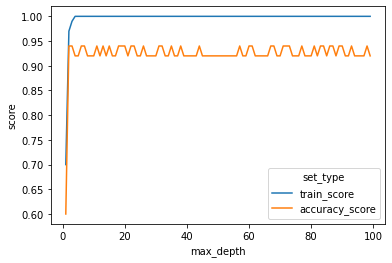

In [ ]:
train_iris_data = pd.read_csv('train_iris_karpov_course.csv', index_col = 0)  # Загружаем данные
test_iris_data = pd.read_csv('test_iris_karpov_course.csv', index_col = 0)

X_train, y_train = train_iris_data.drop('species', axis = 1), train_iris_data.species  # Разделяем выборку на train и test
X_test, y_test = test_iris_data.drop('species', axis = 1), test_iris_data.species

max_depth_values = range(1, 100)     # Создаем массив с диапазоном от 1 до 99, определяем random.seed
rs = np.random.seed(0)
scores_data = pd.DataFrame()         # Датафорейм, в который поместим итоговые данные

for max_depth in max_depth_values:   # Цикл для подбора параметров глубины дерева
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth, random_state = rs)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_score = clf.score(X_train, y_train)   # Оценка качества на тренировочных данных
    accuracy = accuracy_score(y_test, y_pred)   # Оценка качества на тестовых данных



    temp_score_data = pd.DataFrame({'max_depth' : [max_depth],     # Помещаем данные во временный датафрейм
                                    'train_score' : [train_score],
                                    'accuracy_score' : [accuracy]})
    scores_data = pd.concat([scores_data, temp_score_data])


scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'],   # Преобразуем датафрейм
                          value_vars = ['train_score', 'accuracy_score'],
                          var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = scores_data_long)
plt.show()

### УПРАЖНЕНИЕ  
Некий Анатолий зарегистрировался в приложении знакомств. Алгоритм на основе машинного обучения порекомендовал Анатолию 30 фотографий из 100. Анатолий лайкнул 15 фотографий из 30 предложенных, в дальнейшем выяснилось, что Анатолий мог бы лайкнуть еще 30 фотографий из 70 непредложенных.

Будем считать, что  лайк Анатолия является положительным исходом, а отсутствие лайка - отрицательным. Соответственно предсказанный лайк, совпавший с реальным - True positive, предсказанный лайк, не завершившийся реальным лайком - False positive и т. д. Давайте оценим работу алгоритма с точки зрения метрик качества модели: Precision, Recall, F1_score .

In [ ]:
TP = 15
FN = 30
FP = 15
TN = 40

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

print(f"Precision={Precision}\nRecall={round(Recall,2)}\nF1={F1}")

Precision=0.5
Recall=0.33
F1=0.4


Precision —  важен в ситуациях, где не нужны ложные положительные срабатывания;

Recall — важен там, где не нужны ложные отрицательные.

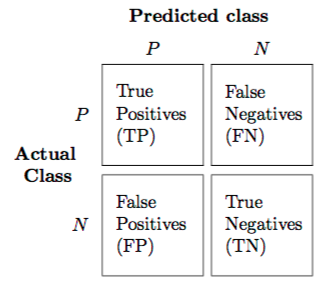

### УПРАЖНЕНИЕ
Поупражняемся в расчётах precision. В задании даны переменные, содержащие информацию о песнях и артистах - X_train, y_train, X_test, y_test. Для каждой песни  посчитаны длина и количество некоторых знаков пунктуации.  
- Обучите модель на тренировочных данных, предскажите авторов для тестовых и поместите в переменную predictions.   
- Затем посчитайте precision score на предсказаниях и y_test, укажите параметр average = 'micro', и сохраните результат в переменную precision.  
- Если он будет недостаточно высок, повысьте качество модели.

In [ ]:
songs = pd.read_csv('songs.csv')   # Загрузим данные
songs['artist'] = songs.artist.map({'abba' : 1, 'gangstarr' : 2, 'blind-guardian' : 3})  # Преобразуем целевой столбец
songs.drop(['song', 'artist', 'genre', 'lyrics'], axis = 1)

,year,length,commas,exclamations,colons,hyphens
0,2007,1300,24,5,0,11
1,2006,1566,0,0,0,0
2,2006,996,1,0,1,0
3,2015,2868,5,0,0,0
4,2014,3351,22,0,0,3
...,...,...,...,...,...,...
355,2006,972,2,0,0,1
356,1995,1283,33,0,0,3
357,1981,810,1,0,0,0
358,2006,1996,34,0,0,5


In [ ]:
songs = pd.read_csv('songs.csv')   # Загрузим данные
songs['artist'] = songs.artist.map({'abba' : 1, 'gangstarr' : 2, 'blind-guardian' : 3})    # Преобразуем целевой столбец
X, y =  songs.drop(['song', 'artist', 'genre', 'lyrics'], axis = 1), songs.artist          # Разделим выборку на X и y

# Разделим выборку на тренировочную и тестовую, обучим классификатор, сделаем предсказание
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

# Цикл для подбора наилучшего показателя глубины дерева
max_precision = 0
best_max_depth = 1

for i in range(1,100):
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = i).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    precision = precision_score(y_test, predictions, average = 'micro')
    if precision > max_precision:
        max_precision = precision
        best_max_depth = i

clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = best_max_depth)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
precision = precision_score(y_test, predictions, average='micro')
print(f'best_max_depth : {best_max_depth}')
print(f'precision: {round(precision,3)}')

best_max_depth : 8
precision: 0.833


In [ ]:
for depth in range(1, 100):
    clf = DecisionTreeClassifier(random_state = 0, criterion = 'entropy', max_depth = depth)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    precision = precision_score(average = 'micro', y_true = y_test, y_pred = predictions)
    if precision >= 0.78:
        break
print(f'max_depth : {depth}')
print(f'precision: {round(precision,3)}')

max_depth : 8
precision: 0.833


#### Подберем наилучший показатель глубины дерева на кросс-валидации

best_max_depth : 13
precision: 0.759


,max_depth,set_type,score
12,13,cross_val_score,0.793971


<AxesSubplot:xlabel='max_depth', ylabel='score'>

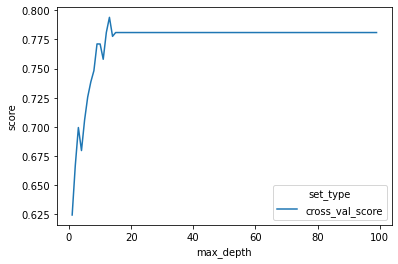

In [ ]:
max_depth_range = range(1,100)
result_df = pd.DataFrame()

for max_depth in max_depth_range:
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=max_depth)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    temporary_df = pd.DataFrame({'max_depth':[max_depth], 'cross_val_score':[mean_cross_val_score]})
    result_df = pd.concat([result_df, temporary_df])

best_max_depth = int(result_df.loc[result_df.cross_val_score == result_df.cross_val_score.max()].head(1).values[0][0])
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth = best_max_depth).fit(X_train, y_train)
predictions = clf.predict(X_test)
precision = precision_score(y_test, predictions, average = 'micro')

print(f'best_max_depth : {best_max_depth}')
print(f'precision: {round(precision, 3)}')

melted_df = pd.melt(result_df, id_vars = ['max_depth'], value_vars = ['cross_val_score'],
                    var_name = 'set_type', value_name = 'score')
max_score  = melted_df.loc[melted_df.score == melted_df.score.max()]
display(max_score)

sns.lineplot(x = 'max_depth', y =  'score', hue ='set_type', data = melted_df)

### УПРАЖНЕНИЕ   
Скачайте набор данных с тремя переменными: sex, exang, num. Представьте, что при помощи дерева решений мы хотим классифицировать есть или нет у пациента заболевание сердца (переменная num), основываясь на двух признаках: пол (**sex**) и  наличие / отсутсвие стенокардии (**exang**).   
- Обучите дерево решений на этих данных, используйте entropy в качестве критерия.    
-Укажите, чему будет равняться значение Information Gain для переменной,  которая будет помещена в корень дерева.

РЕШЕНИЕ 1

,sex,exang,num
0,1,1,1
1,1,1,1
2,1,0,1


[Text(0.5, 0.8333333333333334, 'exang <= 0.5\nentropy = 0.996\nsamples = 238\nvalue = [128, 110]\nclass = sick'),
 Text(0.25, 0.5, 'sex <= 0.5\nentropy = 0.903\nsamples = 157\nvalue = [107, 50]\nclass = sick'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.612\nsamples = 53\nvalue = [45, 8]\nclass = sick'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.973\nsamples = 104\nvalue = [62, 42]\nclass = sick'),
 Text(0.75, 0.5, 'sex <= 0.5\nentropy = 0.826\nsamples = 81\nvalue = [21, 60]\nclass = well'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.954\nsamples = 16\nvalue = [6, 10]\nclass = well'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.779\nsamples = 65\nvalue = [15, 50]\nclass = well')]

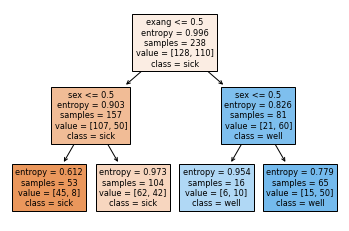

In [ ]:
train_data_tree = pd.read_csv('train_data_tree.csv')  # Загрузим данные и выведем первые три строки датасета
display(train_data_tree.head(3))

X, y = train_data_tree[['sex', 'exang']], train_data_tree.num   # Разделим данные на X и y. Обучим классификатор
clf = DecisionTreeClassifier(criterion = 'entropy').fit(X,y)

tree.plot_tree(clf, feature_names = list(X), class_names = ['sick', 'well'], filled = True)  # Визуализируем данные

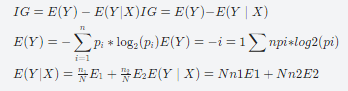

In [ ]:
# Расчет IG вручную
IG = round(0.996 - (0.903 * 157 / 238 + 0.826 * 81 / 238), 3)
print(f'Information Gain (IG) для переменной, которая помещена в корень дерева, = {IG}')

Information Gain (IG) для переменной, которая помещена в корень дерева, = 0.119


РЕШЕНИЕ 2

In [ ]:
# Загрузим данные, разделим выборку на X и y, обучим модель
df = pd.read_csv('train_data_tree.csv')
X, y = df[['sex', 'exang']], df[['num']]
dt = DecisionTreeClassifier(criterion = 'entropy').fit(X, y)

e0 = dt.tree_.impurity[0]                  # Энтропия в коне дерева
left_node = dt.tree_.children_left[0]      # Индекс корня левого поддерева
nl = dt.tree_.n_node_samples[left_node]    # Сэмплов в левом поддереве
el = dt.tree_.impurity[left_node]          # Энтропия в корне левого поддерева
nr = dt.tree_.n_node_samples[right_node]   # Сэмплов в правом поддереве
er = dt.tree_.impurity[right_node]         # Энтропия в корне правого поддерева
ig = e0 - (nl * el + nr * er) / (nl + nr)

# Прирост информации в корне
round(ig, 3)

0.119

РЕШЕНИЕ 3

In [ ]:
# Загрузим данные, обучим модель
sex_exang_num = pd.read_csv('train_data_tree.csv')

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
tree.fit(sex_exang_num.loc[:, ['sex', 'exang']], sex_exang_num['num'])

N = tree.tree_.n_node_samples[0]   # Количество сэмплов
tree.tree_.impurity[0] - (np.dot(tree.tree_.n_node_samples[1:], tree.tree_.impurity[1:])) / N

РЕШЕНИЕ 4

In [ ]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)

data = pd.read_csv("https://stepik.org/media/attachments/course/4852/train_data_tree.csv")
X_train = data.drop("num", axis = 1)
y_train = data.num

dt.set_params(criterion = "entropy")
dt.fit(X_train, y_train)

ig = [0] * dt.tree_.node_count
for i in range(dt.tree_.node_count):
    left = dt.tree_.children_left[i] if dt.tree_.children_left[i] != -1 else 0
    right = dt.tree_.children_right[i] if dt.tree_.children_right[i] != -1 else 0

    if left:
        left = dt.tree_.n_node_samples[left] * dt.tree_.impurity[left] / dt.tree_.n_node_samples[i]
    if right:
        right = dt.tree_.n_node_samples[right] * dt.tree_.impurity[right] / dt.tree_.n_node_samples[i]

    ig[i] = dt.tree_.impurity[i] - left - right

print([round(x, 3) for x in ig])
print([round(x, 3) for x in ig][0])

[0.119, 0.051, 0.612, 0.973, 0.012, 0.954, 0.779]
0.119


- **Случайный лес - композиция глубоких деревьев, которые строятся независимо друг от друга.**  
- При очень маленьком числе деревьев (5, 10, 15) случайный лес работает хуже, чем при большем количестве деревьев.  
- С ростом количества деревьев в случайном лесу, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется. (Каждое новое дерево в ансамбле строится независимо от ранее построенного. Чтобы нивелировать вклад ошибок отдельных классификаторов, требуется строить большое кол-во деревьев.)
- При большом количестве признаков (для данного датасета - 40-50) качество классификации становится хуже, чем при малом количестве признаков (10-15). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.  
- При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, так как из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге несильно сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг друга). Однако для достижения наилучшего качества необходимо подбирать оптимальную глубину.
- Построение глубоких деревьев требует высокой вычислительной мощности особенно в случае большой выборки или большого количества признаков. Неглубокие деревья в Random Forest перестают улавливать сложные закономерности в данных. Это может привести к тому, что сдвиг (bias) будет слишком большим.
- **Необходимо определять оптимальную глубину дерева и другие параметры (например, при помощи Optuna, GridSearchCV etc).**
